In [20]:
import numpy as np
import pandas as pd
import pylab as pl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [21]:
df = pd.read_csv("movies_metadata.csv")

C:\Users\Apurva\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We need only the numeric columns for our analysis. 

However, we'll keep titles also to interpret the results at the end of clustering. Note that this title column will not be used in the analysis.

In [22]:
df.drop(df.index[19730],inplace=True)
df.drop(df.index[29502],inplace=True)
df.drop(df.index[35585],inplace=True)

In [23]:
df_numeric = df[['budget','popularity','revenue','runtime','vote_average','vote_count','title']]

In [24]:
df_numeric.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,title
0,30000000,21.9469,373554033.0,81.0,7.7,5415.0,Toy Story
1,65000000,17.0155,262797249.0,104.0,6.9,2413.0,Jumanji
2,0,11.7129,0.0,101.0,6.5,92.0,Grumpier Old Men
3,16000000,3.85949,81452156.0,127.0,6.1,34.0,Waiting to Exhale
4,0,8.38752,76578911.0,106.0,5.7,173.0,Father of the Bride Part II


In [25]:
# Check if rows contain any null values
df_numeric.isnull().sum()

budget            0
popularity        3
revenue           3
runtime         260
vote_average      3
vote_count        3
title             3
dtype: int64

In [26]:
# Drop all the rows with null values
df_numeric.dropna(inplace=True)

C:\Users\Apurva\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
# some statistics about the data
df_numeric['vote_count'].describe()

count    45203.000000
mean       110.506515
std        492.638190
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

We see that a half of movies have been rated less than 10 times. 

For easier interpretability, let's take only the movies that have more than 30 votes, i.e. top 26% of the movies.

In [28]:
df_numeric['vote_count'].quantile(np.arange(.74,1,0.01))

0.74      32.00
0.75      34.00
0.76      37.00
0.77      40.00
0.78      43.00
0.79      46.00
0.80      51.00
0.81      55.00
0.82      61.00
0.83      67.00
0.84      74.00
0.85      83.00
0.86      92.00
0.87     104.74
0.88     119.00
0.89     139.00
0.90     161.00
0.91     193.00
0.92     230.00
0.93     283.00
0.94     349.00
0.95     435.90
0.96     581.00
0.97     827.94
0.98    1243.88
0.99    2196.84
Name: vote_count, dtype: float64

In [29]:
df_numeric = df_numeric[df_numeric['vote_count']>30]

In [30]:
df_numeric.shape

(12178, 7)

In [31]:
# Normalize the data with MinMax scaling provided by sklearn

In [32]:
from sklearn import preprocessing

minmax_processed = preprocessing.MinMaxScaler().fit_transform(df_numeric.drop('title',axis=1))

In [33]:
df_numeric_scaled = pd.DataFrame(minmax_processed, index=df_numeric.index, columns=df_numeric.columns[:-1])

In [34]:
df_numeric_scaled.head()

,budget,popularity,revenue,runtime,vote_average,vote_count
0,0.078947,0.040082,0.133988,0.092360,0.810526,0.383367
1,0.171053,0.031075,0.094261,0.118586,0.726316,0.169610
2,0.000000,0.021389,0.000000,0.115165,0.684211,0.004343
3,0.042105,0.007045,0.029216,0.144812,0.642105,0.000214
4,0.000000,0.015315,0.027468,0.120867,0.600000,0.010111



What k to choose?

Let's fit cluster size 1 to 20 on our data and take a look at the corresponding score value.


In [35]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]

In [36]:
score = [kmeans[i].fit(df_numeric_scaled).score(df_numeric_scaled) for i in range(len(kmeans))]

These score values signify how far our observations are from the cluster center. We want to keep this score value around 0. A large positive or a large negative value would indicate that the cluster center is far from the observations.

Based on these scores value, we plot an Elbow curve to decide which cluster size is optimal. Note that we are dealing with tradeoff between cluster size(hence the computation required) and the relative accuracy.


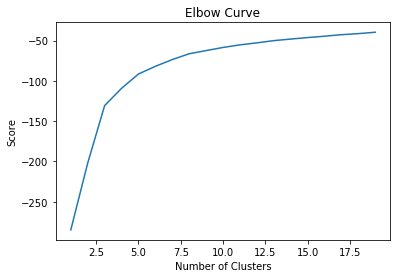

In [37]:
pl.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

Our Elbow point is around cluster size of 5. We will use k=5 to further interpret our clustering result. 

In [38]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_numeric_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

As a result of clustering, we have the clustering label. 
Let's put these labels back into the original numeric data frame.

In [39]:
len(kmeans.labels_)

12178

In [40]:
df_numeric['cluster'] = kmeans.labels_

In [41]:
df_numeric.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,title,cluster
0,30000000,21.9469,373554033.0,81.0,7.7,5415.0,Toy Story,3
1,65000000,17.0155,262797249.0,104.0,6.9,2413.0,Jumanji,0
2,0,11.7129,0.0,101.0,6.5,92.0,Grumpier Old Men,1
3,16000000,3.85949,81452156.0,127.0,6.1,34.0,Waiting to Exhale,1
4,0,8.38752,76578911.0,106.0,5.7,173.0,Father of the Bride Part II,1


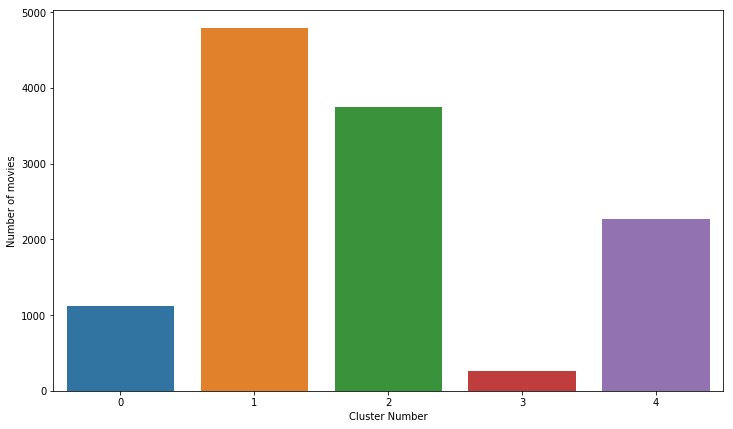

In [42]:
# Let's see cluster sizes first.
plt.figure(figsize=(12,7))
axis = sns.barplot(x=np.arange(0,5,1),y=df_numeric.groupby(['cluster']).count()['budget'].values)
x=axis.set_xlabel("Cluster Number")
x=axis.set_ylabel("Number of movies")

# We clearly see that one cluster is the largest and one cluster has the fewest number of movies.

In [43]:
size_array = list(df_numeric.groupby(['cluster']).count()['budget'].values)

In [46]:
size_array

[1121, 4787, 3743, 260, 2267]

In [47]:
df_numeric[df_numeric['cluster']==size_array.index(sorted(size_array)[0])].sample(5)

,budget,popularity,revenue,runtime,vote_average,vote_count,title,cluster
24860,14000000,31.5959,233555708.0,113.0,8.0,5895.0,The Imitation Game,3
13605,70000000,16.8956,319131050.0,153.0,7.9,6598.0,Inglourious Basterds,3
475,63000000,8.86378,920100000.0,127.0,7.6,4956.0,Jurassic Park,3
24873,125000000,147.098,752100229.0,123.0,6.6,5767.0,The Hunger Games: Mockingjay - Part 1,3
2572,150000000,12.4535,448000000.0,88.0,7.1,1715.0,Tarzan,3
